<a href="https://colab.research.google.com/github/suminarwb/hate-speech-id/blob/main/LSTM_labeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import os
import pandas as pd
from tqdm.auto import tqdm
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from gensim.models import FastText
import numpy as np # linear algebra

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Import everything that will be used
import string
import random
import logging
from keras.models import Sequential
from keras.layers import *
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Mounted at /content/drive


In [9]:
data = pd.read_excel("/content/drive/My Drive/Tesis/dataset_basic.xlsx", sheet_name='Sheet1' )

df = pd.DataFrame(data, columns=['Tweet', 'HS', 'Subject', 'Category'])
df.Tweet.astype(str)
df.Subject.astype(str)
df.Category.astype(str)
df.head()

,Tweet,HS,Subject,Category
0,disaat semua cowok berusaha melacak perhatian ...,1,Individual,Other
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,None,None
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,None,None
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,None,None
4,USER USER Kaum cebong kapir udah keliatan dong...,1,Group,Religion


In [10]:
df.shape

(13169, 4)

In [11]:
df.dropna(subset=['Tweet'])

,Tweet,HS,Subject,Category
0,disaat semua cowok berusaha melacak perhatian ...,1,Individual,Other
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,None,None
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,None,None
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,None,None
4,USER USER Kaum cebong kapir udah keliatan dong...,1,Group,Religion
...,...,...,...,...
13164,USER jangan asal ngomong ndasmu. congor lu yg ...,1,Individual,Physical
13165,USER Kasur mana enak kunyuk',0,None,None
13166,USER Hati hati bisu :( .g\n\nlagi bosan huft \...,0,None,None
13167,USER USER USER USER Bom yang real mudah terdet...,0,None,None


In [12]:
df.shape

(13169, 4)

In [13]:
# Create an iterator object that returns words properly formatted for Word2Vec training
class TweetsIterator:
    def __init__(self, dataset):
        self.dataset = dataset

        # The text contains a stupid special character, hence the + '–'
        self.translator = str.maketrans('', '', string.punctuation + '–')

    def __iter__(self):
        for review in self.dataset.iloc[:, 0]:
            # Make all characters lower-case
            #print(review)
            review =  review.lower()
            
            #[:-1] means 0 to n-1 column. cause last element after the last full stop is null. 
            for sentence in review.split('.')[:-1]:
                # Clean string of all punctuation
                #sentence = sentence.translate(self.translator)

                words = [w for w in sentence.split(' ') if w != '']

                yield words
                
sentences = TweetsIterator(df)

In [14]:
#w2v_model = FastText(sentences, size=100, window=5, min_count=10, workers=8)

#w2v_model.save('/content/drive/My Drive/Tesis/fasttext_trained_model')

In [15]:
fasttext_model = FastText.load('/content/drive/My Drive/Tesis/model.fasttext')
w2v_model = fasttext_model

In [16]:
ft_weights = fasttext_model.wv.vectors

In [17]:
vocab_size, embedding_size = ft_weights.shape
print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

Vocabulary Size: 8076 - Embedding Dim: 100


In [18]:
import pickle

In [19]:
#with open("/content/drive/My Drive/Tesis/fasttext_final_vector.pickle", "wb") as fp:   #Pickling
#   pickle.dump(ft_weights, fp)

In [20]:
#with open("/content/drive/My Drive/Tesis/fasttext_final_vector.pickle", "rb") as fp:   # Unpickling
#    ft_weights = pickle.load(fp)

In [21]:
fasttext_model_wv = fasttext_model.wv

In [22]:
fasttext_model_wv.most_similar('dungu!!!')

[('dungu', 0.8773057460784912),
 ('dungu..', 0.7845500707626343),
 ('dungunya', 0.7240412831306458),
 ('kedunguan', 0.4280564486980438),
 ('mungut', 0.3871338367462158),
 ('kedunguannya', 0.3730772137641907),
 ('petunjuk', 0.36233067512512207),
 ('gadungan', 0.35159823298454285),
 ('kotor', 0.3456292748451233),
 ('sampah', 0.3453337252140045)]

In [23]:
#function
def word2token(word):
    try:
        return w2v_model.wv.vocab[word].index
    # If word is not in index return 0. I realize this means that this
    # is the same as the word of index 0 (i.e. most frequent word), but 0s
    # will be padded later anyway by the embedding layer (which also
    # seems dirty but I couldn't find a better solution right now)
    except KeyError:
        return 0
def token2word(token):
    return w2v_model.wv.index2word[token]

In [24]:
fasttext_model_wv['dungu']

array([-0.2542859 , -2.1411407 ,  3.670874  ,  0.9861122 ,  3.8132467 ,
       -3.1784782 , -0.22637776, -1.8077937 , -4.400698  ,  0.0915356 ,
        1.4126471 ,  2.4728444 ,  3.5107813 ,  2.2410011 ,  0.27023977,
        3.2908387 ,  0.11950523, -0.57991296,  0.08745129, -3.171089  ,
        2.9007924 , -0.9098482 ,  0.57036054, -3.3122818 , -4.1031775 ,
       -0.87985206,  4.231088  ,  0.59913164,  3.2677789 , -0.8784371 ,
       -0.87041104,  0.18819025, -1.0613414 , -2.7010233 ,  3.2248607 ,
       -1.8209234 , -3.5992727 ,  0.7778394 ,  0.9186775 ,  1.9489349 ,
       -2.0054638 ,  2.243134  , -0.3328041 ,  0.26728195, -2.416629  ,
        1.2194216 , -0.21499214, -1.1933204 , -1.9292055 ,  1.0848664 ,
        1.2075679 , -1.2340539 ,  1.988107  , -1.4722354 , -1.0619259 ,
       -1.9179606 ,  1.8279775 ,  4.8618617 ,  0.00695113, -0.17490408,
       -0.47767523,  2.0252674 ,  0.8798815 , -0.32636437,  2.2531297 ,
       -4.082669  , -4.335689  , -1.7987186 , -1.3843114 ,  0.06

In [25]:
from sklearn.manifold import TSNE

In [26]:
vocab_size, embedding_layer_input_size = ft_weights.shape
print(vocab_size, embedding_layer_input_size)

8076 100


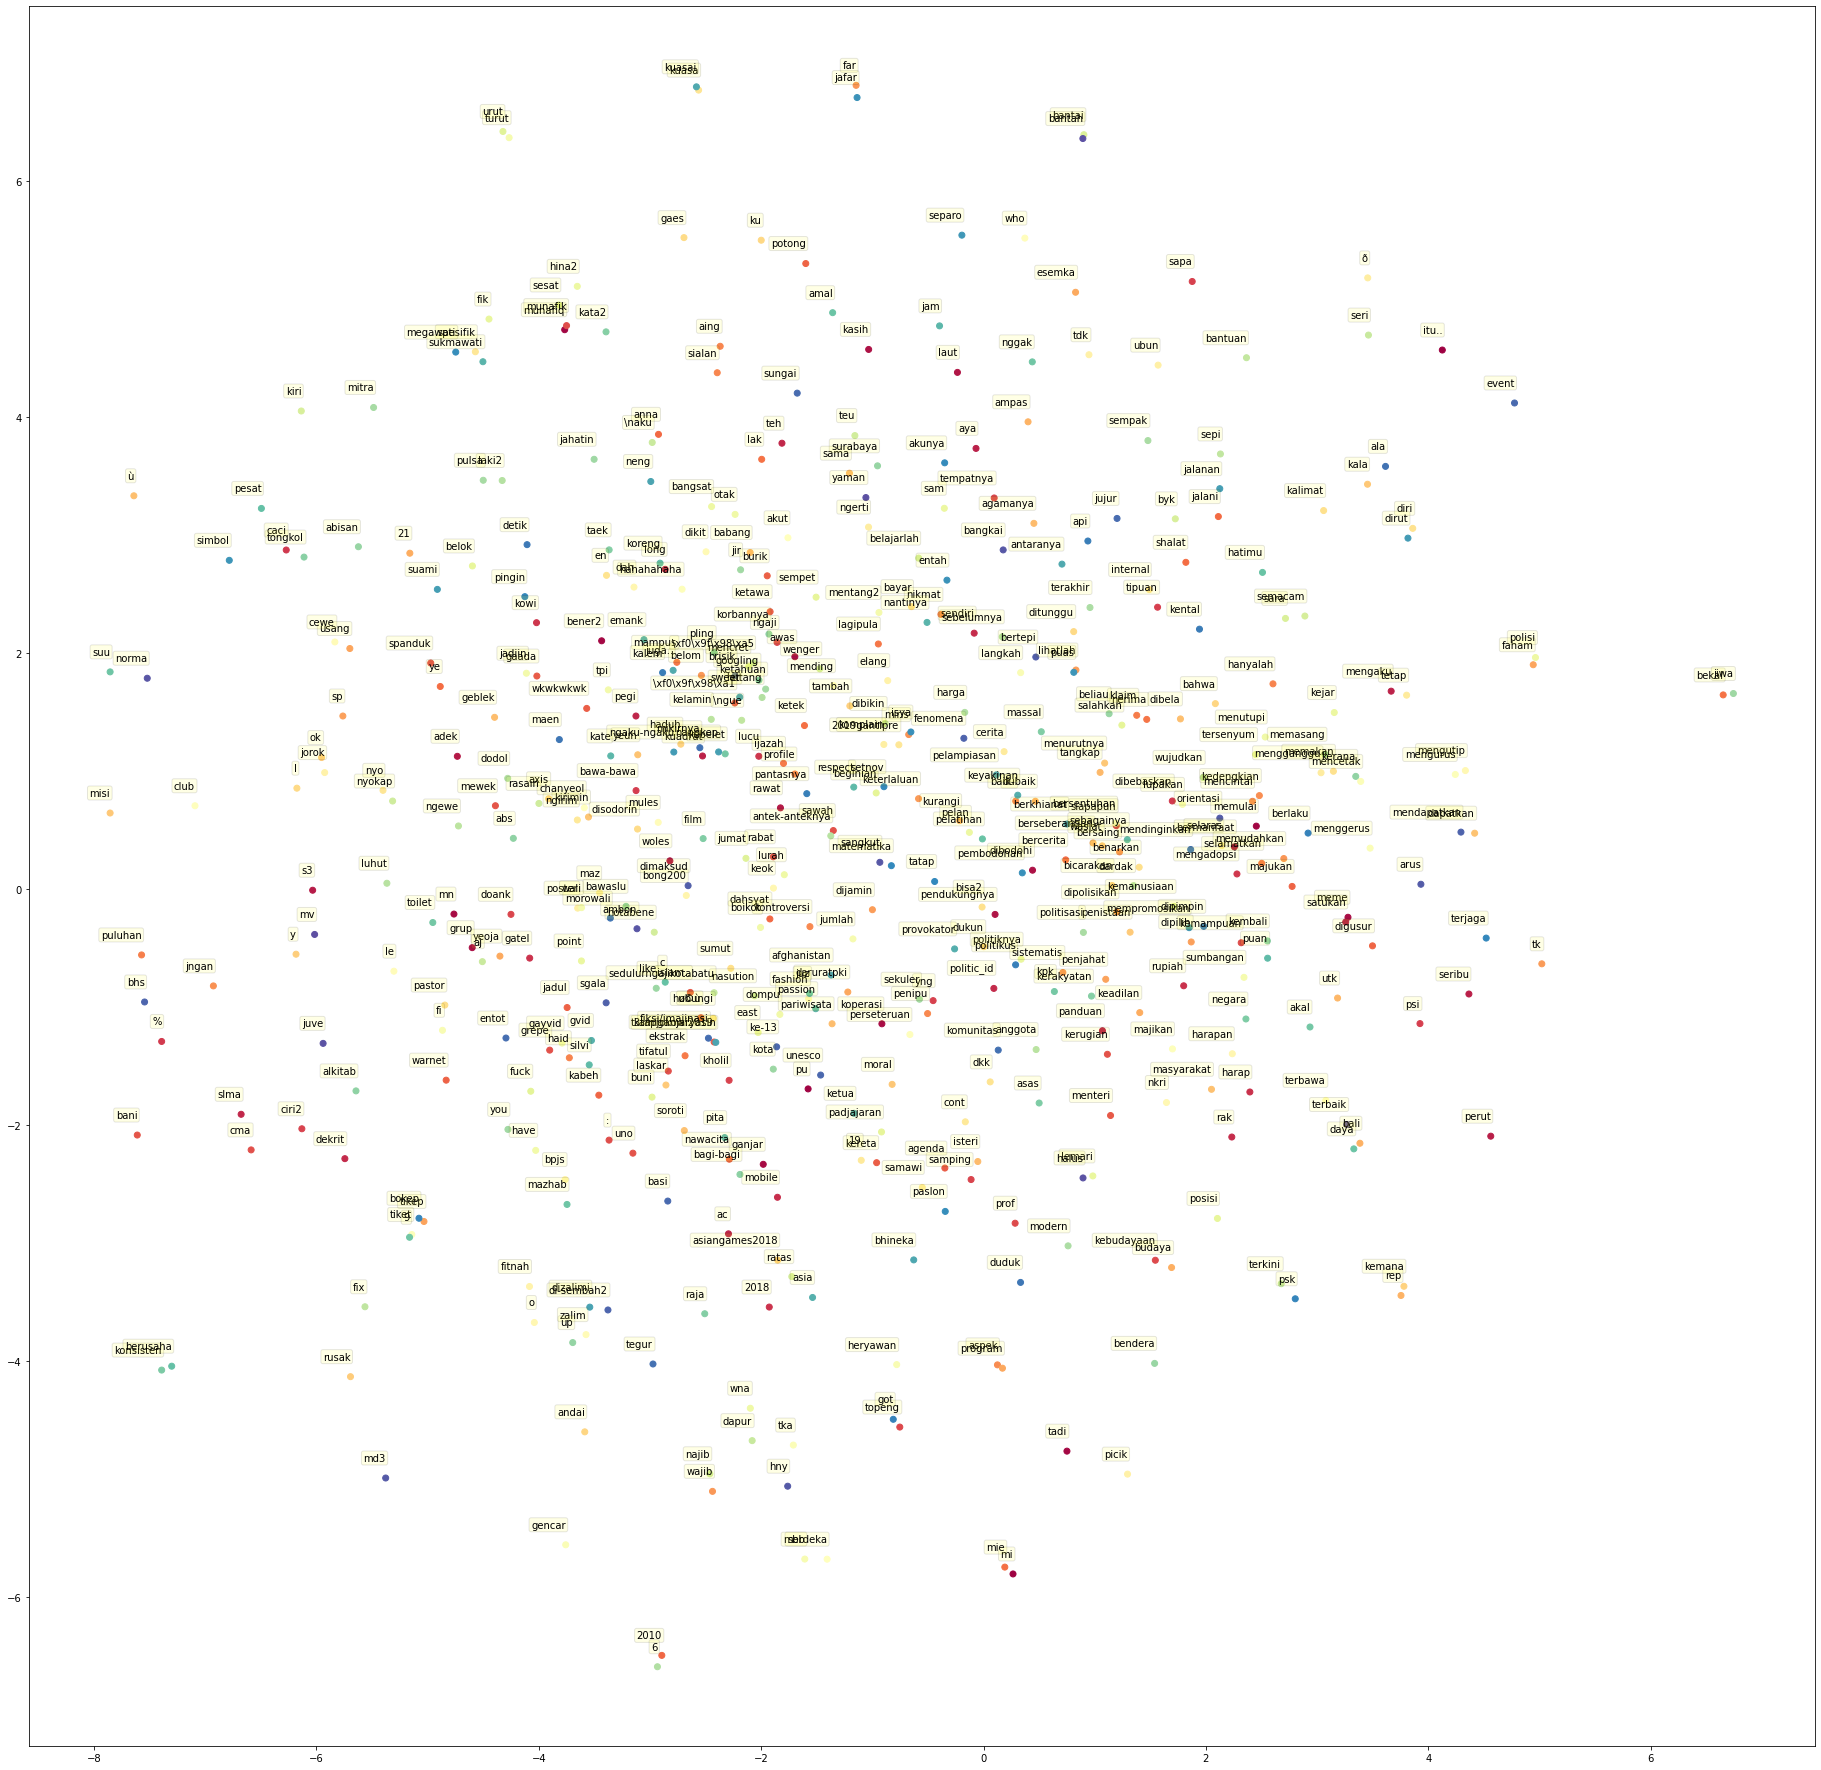

In [47]:
n_samples = 500
# Sample random words from model dictionary
random_i = random.sample(range(vocab_size), n_samples)
random_w = [token2word(i) for i in random_i]

# Generate fasttext embeddings of each word
word_vecs = np.array([fasttext_model_wv[w] for w in random_w])

# Apply t-SNE to Word2Vec embeddings, reducing to 2 dims
tsne = TSNE()
tsne_e = tsne.fit_transform(word_vecs)

# Plot t-SNE result
plt.figure(figsize=(32, 32))
plt.scatter(tsne_e[:, 0], tsne_e[:, 1], marker='o', c=range(len(random_w)), cmap=plt.get_cmap('Spectral'))

for label, x, y, in zip(random_w, tsne_e[:, 0], tsne_e[:, 1]):
    plt.annotate(label,
                 xy=(x, y), xytext=(0, 15),
                 textcoords='offset points', ha='right', va='bottom',
                 bbox=dict(boxstyle='round, pad=0.2', fc='yellow', alpha=0.1))

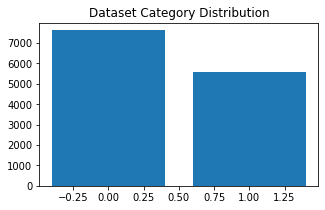

In [28]:
categories, ccount = np.unique(df.HS, return_counts=True)

plt.figure(figsize=(5, 3))
plt.title("Dataset Category Distribution")
plt.bar(categories, ccount, align='center')
plt.show()

In [29]:
df.shape

(13169, 4)

In [30]:
def word2idx(word):
    try:
        return fasttext_model_wv.vocab[word].index
    # If word is not in index return 0. I realize this means that this
    # is the same as the word of index 0 (i.e. most frequent word), but 0s
    # will be padded later anyway by the embedding layer (which also
    # seems dirty but I couldn't find a better solution right now)
    except KeyError:
        return 0
    
def idx2word(idx):
    return fasttext_model_wv.index2word[idx]

In [31]:

# Create an iterator that formats data from the dataset proper for
# LSTM training

# Sequences will be padded or truncated to this length
MAX_SEQUENCE_LENGTH = 200

# Samples of categories with less than this number of samples will be ignored

class SequenceIterator:
    def __init__(self, dataset, seq_length):
        self.dataset = dataset

        self.translator = str.maketrans('', '', string.punctuation + '–')
        self.HS, self.ccount = np.unique(dataset.HS, return_counts=True)
        
        self.seq_length = seq_length
        
    def __iter__(self):
        for review, score in zip(self.dataset.iloc[:,0], self.dataset.iloc[:,1]):
            # Make all characters lower-case
            review = str(review).lower()
            
            # Clean string of all punctuation
            #review = review.translate(self.translator)

            words = np.array([word2idx(w) for w in review.split(' ')[:self.seq_length] if w != ''])
                                
            # basically what is being done here is this - we take the review and score of a row. 
            # then we send the score intact
            # but, we take the review and split it into an array of words. then those words are searched in the fasttext_model_wv
            # and their index in that model's internal map / dictionary is found. those indexes are saved in an array. 
            # this array is padded with 0 so that these can be of MAX_LENGTH
            # replacing not found elements with 0 doesn't harm as it's the most used word, it will be ignored at some point. 
            
            yield (words, score)

sequences = SequenceIterator(df, MAX_SEQUENCE_LENGTH)

In [88]:
# Used for generating the labels in the set
# cat_dict = {k: v for k, v in zip(sequences.categories, range(len(sequences.categories)))}

# we don't need this dictionary actually as our score field itself contains integer values. 
# although if you want you can name them. 

score_dict = {
                0 : 'Netral', 
                1 : 'Hate Speech'
             }


set_x = []
set_y = []

for w, s in sequences:
    set_x.append(w)
    set_y.append(s)
#    
#    
## Padding sequences with 0.
#
set_x = pad_sequences(set_x, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', value=0)
set_y = np.array(set_y)
#set_individu = np.array(set_individu)
#set_group = np.array(set_group)
#set_religion = np.array(set_religion)
#set_race = np.array(set_race)
#set_physical = np.array(set_physical)
#set_gender = np.array(set_gender)


In [55]:
print(set_x.shape)

# set_y just has the score values serially. 

print(set_y.shape)

print(set_y)


(13169, 200)
(13169,)
[1 0 0 ... 0 0 1]


Train Shapes - X: (10535, 200) - Y: (10535,)
Val Shapes - X: (2634, 200) - Y: (2634,)


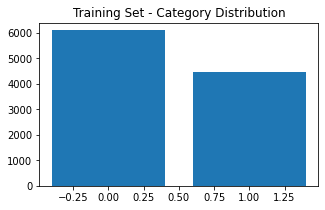

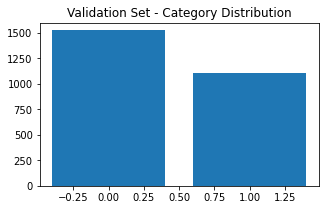

[1524 1110]


In [89]:
VALID_PER = 0.20 # Percentage of the whole set that will be separated for validation

from sklearn.model_selection import train_test_split
total_samples = set_x.shape[0]
n_val = int(VALID_PER * total_samples)
n_train = total_samples - n_val

#random_i = random.sample(range(total_samples), total_samples)
#train_x = set_x[random_i[:n_train]]
#train_y = set_y[random_i[:n_train]]
#val_x = set_x[random_i[n_train:n_train+n_val]]
#val_y = set_y[random_i[n_train:n_train+n_val]]

train_x, val_x, train_y, val_y = train_test_split(set_x, set_y, test_size=VALID_PER, shuffle=False)

print("Train Shapes - X: {} - Y: {}".format(train_x.shape, train_y.shape))
print("Val Shapes - X: {} - Y: {}".format(val_x.shape, val_y.shape))

# Let's look at the distribution of categories in both sets
categories, ccount = np.unique(train_y, return_counts=True)
plt.figure(figsize=(5,3))
plt.title("Training Set - Category Distribution")
# plt.xticks(range(len(score_dict)), score_dict.values())
plt.bar(categories, ccount, align='center')
plt.show()

categories, ccount = np.unique(val_y, return_counts=True)
plt.figure(figsize=(5,3))
plt.title("Validation Set - Category Distribution")
# plt.xticks(range(len(categories)), cat_dict.keys())
plt.bar(categories, ccount, align='center')
plt.show()

print(ccount)

n_categories = len(categories)


In [90]:
vocab_size, embedding_layer_output_size = ft_weights.shape
print(vocab_size, embedding_layer_output_size)

print(train_y)

8076 100
[1 0 0 ... 1 0 0]


In [91]:
from keras.models import Model
x = set_x
input =  Input(shape=(set_x.shape[1],))
x = Embedding(input_dim=vocab_size, # 34867
                    output_dim=embedding_layer_output_size, # 100
                    weights=[ft_weights],
                    input_length=MAX_SEQUENCE_LENGTH, # 200
                    mask_zero=True,
                    trainable=False)(input)
x = SpatialDropout1D(0.2)(x)
x = LSTM(20, dropout=0.2, recurrent_dropout=0.2)(x)
out1 = Dense(n_subjects, activation='softmax', name='hs')(x)
model = Model(inputs = input, outputs=[out1])


loss_name = 'categorical_crossentropy'

train_y = pd.get_dummies(train_y).values

val_y = pd.get_dummies(val_y).values



model.compile(optimizer='adam', loss=loss_name, metrics=['accuracy'])

history = model.fit(x=train_x, y={"hs" : train_y}, epochs=10, batch_size=32, validation_data=(val_x, {"hs" : val_y}), verbose=1, shuffle=False)

Epoch 1/10
330/330 [==============================] - 81s 231ms/step - loss: 0.6751 - accuracy: 0.5918 - val_loss: 0.5462 - val_accuracy: 0.7149
Epoch 2/10
330/330 [==============================] - 75s 226ms/step - loss: 0.5514 - accuracy: 0.7209 - val_loss: 0.4844 - val_accuracy: 0.7677
Epoch 3/10
330/330 [==============================] - 74s 225ms/step - loss: 0.5087 - accuracy: 0.7476 - val_loss: 0.4571 - val_accuracy: 0.7916
Epoch 4/10
330/330 [==============================] - 74s 224ms/step - loss: 0.4939 - accuracy: 0.7597 - val_loss: 0.4454 - val_accuracy: 0.7999
Epoch 5/10
330/330 [==============================] - 74s 224ms/step - loss: 0.4747 - accuracy: 0.7731 - val_loss: 0.4369 - val_accuracy: 0.8037
Epoch 6/10
330/330 [==============================] - 75s 227ms/step - loss: 0.4671 - accuracy: 0.7766 - val_loss: 0.4372 - val_accuracy: 0.7973
Epoch 7/10
330/330 [==============================] - 75s 227ms/step - loss: 0.4555 - accuracy: 0.7873 - val_loss: 0.4368 - val_ac

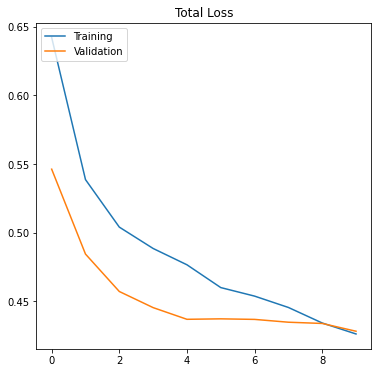

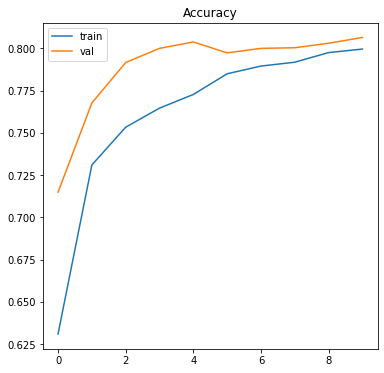

In [92]:
# Plotting Loss and Accuracy Graphs
plt.figure(figsize=(6, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Total Loss')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()


plt.figure(figsize=(6, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [100]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, confusion_matrix

y_pred = model.predict(val_x, verbose=1, batch_size=64)
y_pred_bool = np.argmax(y_pred, axis=1)

val_true = np.argmax(val_y, axis=1)

print(classification_report(val_true, y_pred_bool, digits=4))
print('Precision Score : ', precision_score(val_true, y_pred_bool , average="macro"))
print('Recall Score : ', recall_score(val_true, y_pred_bool , average="macro"))
print('F1 Score : ', f1_score(val_true, y_pred_bool , average="macro"))

(tn, fp, fn, tp) = confusion_matrix(val_true, y_pred_bool).ravel()

print((tn, fp, fn, tp) )

print(y_pred_bool)

42/42 [==============================] - 2s 41ms/step
              precision    recall  f1-score   support

           0     0.8201    0.8524    0.8359      1524
           1     0.7857    0.7432    0.7639      1110

    accuracy                         0.8064      2634
   macro avg     0.8029    0.7978    0.7999      2634
weighted avg     0.8056    0.8064    0.8056      2634

Precision Score :  0.8028950216450217
Recall Score :  0.7978027239838263
F1 Score :  0.7998981123981124
(1299, 225, 285, 825)
[0 0 0 ... 0 0 1]


In [101]:
accr = model.evaluate(val_x, val_y)
print(accr)
print('Test set\n  Loss HS: {:0.3f}\n  Accuracy HS: {:0.3f}'.format(accr[0], accr[1]))


83/83 [==============================] - 4s 33ms/step - loss: 0.4282 - accuracy: 0.8064
[0.4281892776489258, 0.8063781261444092]
Test set
  Loss HS: 0.428
  Accuracy HS: 0.806


In [102]:
model.save("/content/drive/My Drive/Tesis/model_hs_32")

INFO:tensorflow:Assets written to: /content/drive/My Drive/Tesis/model_hs_32/assets


Model Labeling HS

In [103]:
class SequenceIteratorCategories:
    def __init__(self, dataset, seq_length):
        self.dataset = dataset

        self.translator = str.maketrans('', '', string.punctuation + '–')
        self.Subject, self.ccount = np.unique(dataset.HS, return_counts=True)
        
        self.seq_length = seq_length
        
    def __iter__(self):
        for review, subject, category in zip(self.dataset.iloc[:,0], self.dataset.iloc[:,2], self.dataset.iloc[:,3]):
            # Make all characters lower-case
            review = str(review).lower()
            
            # Clean string of all punctuation
            #review = review.translate(self.translator)

            words = np.array([word2idx(w) for w in review.split(' ')[:self.seq_length] if w != ''])
                                
            # basically what is being done here is this - we take the review and score of a row. 
            # then we send the score intact
            # but, we take the review and split it into an array of words. then those words are searched in the fasttext_model_wv
            # and their index in that model's internal map / dictionary is found. those indexes are saved in an array. 
            # this array is padded with 0 so that these can be of MAX_LENGTH
            # replacing not found elements with 0 doesn't harm as it's the most used word, it will be ignored at some point. 
            
            yield (words, subject, category)

sequences_ = SequenceIteratorCategories(df.loc[df['HS'] == 1], MAX_SEQUENCE_LENGTH)

In [104]:
set_x2 = []
set_sub = []
set_cat = []

for w, s, c in sequences_:
    set_x2.append(w)
    set_sub.append(s)
    set_cat.append(c)
#    
#    
## Padding sequences with 0.
#
set_x2 = pad_sequences(set_x2, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', value=0)
set_sub = np.array(set_sub)
set_cat = np.array(set_cat)

In [105]:
print(set_x2.shape)

# set_y just has the score values serially. 

print(set_cat.shape)

print(set_cat)

(5561, 200)
(5561,)
['Other' 'Religion' 'Other' ... 'Other' 'Physical' 'Other']


Train Shapes - X: (4726, 200) - Y: (4726,)
Val Shapes - X: (835, 200) - Y: (835,)


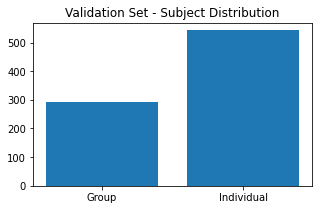

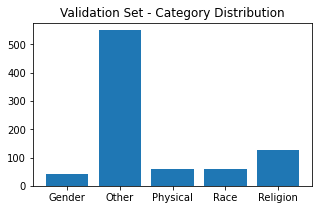

[ 42 549  61  58 125]


In [129]:
VALID_PER = 0.15 # Percentage of the whole set that will be separated for validation

from sklearn.model_selection import train_test_split
total_samples = set_x.shape[0]
n_val = int(VALID_PER * total_samples)
n_train = total_samples - n_val


train_x, val_x, train_sub, val_sub, train_cat, val_cat = train_test_split(set_x2, set_sub, set_cat, test_size=VALID_PER, random_state=42)

print("Train Shapes - X: {} - Y: {}".format(train_x.shape, train_sub.shape))
print("Val Shapes - X: {} - Y: {}".format(val_x.shape, val_sub.shape))

subjects, ccount = np.unique(val_sub, return_counts=True)
plt.figure(figsize=(5,3))
plt.title("Validation Set - Subject Distribution")
# plt.xticks(range(len(categories)), cat_dict.keys())
plt.bar(subjects, ccount, align='center')
plt.show()

categories, ccount = np.unique(val_cat, return_counts=True)
plt.figure(figsize=(5,3))
plt.title("Validation Set - Category Distribution")
# plt.xticks(range(len(categories)), cat_dict.keys())
plt.bar(categories, ccount, align='center')
plt.show()

n_categories = len(categories)
n_subjects = len(subjects)
print(ccount)

In [107]:
from keras.models import Model
x = set_x2
input =  Input(shape=(set_x2.shape[1],))
x = Embedding(input_dim=vocab_size, # 34867
                    output_dim=embedding_layer_output_size, # 100
                    weights=[ft_weights],
                    input_length=MAX_SEQUENCE_LENGTH, # 200
                    mask_zero=True,
                    trainable=False)(input)
x = SpatialDropout1D(0.2)(x)
x = LSTM(20, dropout=0.2, recurrent_dropout=0.2)(x)
out1 = Dense(n_subjects, activation='softmax', name='subject')(x)
out2 = Dense(n_categories, activation='softmax', name='category')(x)
model2 = Model(inputs = input, outputs=[out1, out2])


loss_name = 'categorical_crossentropy'

train_sub_i = pd.get_dummies(train_sub).values
train_cat_i = pd.get_dummies(train_cat).values
val_sub_i = pd.get_dummies(val_sub).values
val_cat_i = pd.get_dummies(val_cat).values


model2.compile(optimizer='adam', loss=loss_name, metrics=['accuracy'])

history = model2.fit(x=train_x, y={"subject" : train_sub_i, "category" : train_cat_i}, epochs=10, batch_size=32, validation_data=(val_x, {"subject" : val_sub_i, "category" : val_cat_i}), verbose=1, shuffle=False)

Epoch 1/10
148/148 [==============================] - 41s 236ms/step - loss: 2.1896 - subject_loss: 0.7209 - category_loss: 1.4687 - subject_accuracy: 0.5194 - category_accuracy: 0.3741 - val_loss: 1.7189 - val_subject_loss: 0.6184 - val_category_loss: 1.1005 - val_subject_accuracy: 0.6623 - val_category_accuracy: 0.6515
Epoch 2/10
148/148 [==============================] - 33s 226ms/step - loss: 1.6766 - subject_loss: 0.6294 - category_loss: 1.0471 - subject_accuracy: 0.6452 - category_accuracy: 0.6622 - val_loss: 1.5771 - val_subject_loss: 0.5759 - val_category_loss: 1.0012 - val_subject_accuracy: 0.7138 - val_category_accuracy: 0.6671
Epoch 3/10
148/148 [==============================] - 33s 226ms/step - loss: 1.5492 - subject_loss: 0.6093 - category_loss: 0.9399 - subject_accuracy: 0.6724 - category_accuracy: 0.6916 - val_loss: 1.4943 - val_subject_loss: 0.5582 - val_category_loss: 0.9361 - val_subject_accuracy: 0.7341 - val_category_accuracy: 0.7078
Epoch 4/10
148/148 [===========

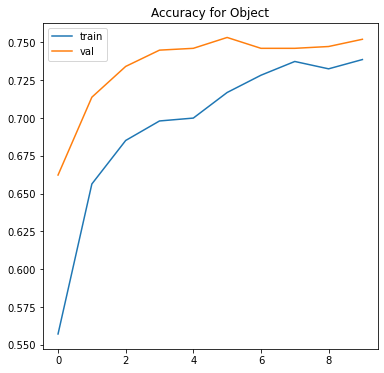

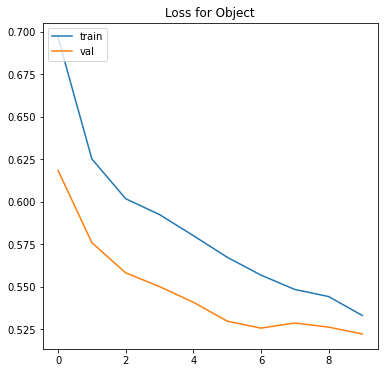

In [245]:
plt.figure(figsize=(6, 6))
plt.plot(history.history['subject_accuracy'])
plt.plot(history.history['val_subject_accuracy'])
plt.title('Accuracy for Object')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(6, 6))
plt.plot(history.history['subject_loss'])
plt.plot(history.history['val_subject_loss'])
plt.title('Loss for Object')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

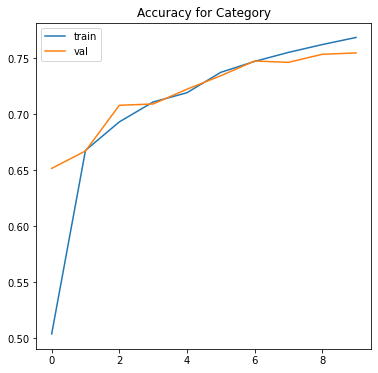

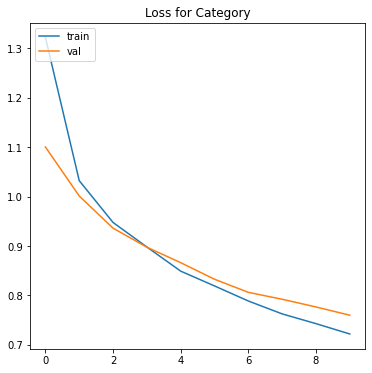

In [109]:
plt.figure(figsize=(6, 6))
plt.plot(history.history['category_accuracy'])
plt.plot(history.history['val_category_accuracy'])
plt.title('Accuracy for Category')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(6, 6))
plt.plot(history.history['category_loss'])
plt.plot(history.history['val_category_loss'])
plt.title('Loss for Category')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [249]:
from sklearn.metrics import multilabel_confusion_matrix, f1_score, precision_score, recall_score, confusion_matrix

(pred_sub, pred_cat) = model2.predict(val_x, verbose=1, batch_size=64)
y_pred_bool = np.argmax(pred_sub, axis=1)
labels = ['Group', 'Individual']

pred_sub_lbl = []

for s in y_pred_bool:
    pred_sub_lbl.append(labels[s])

val_true = val_sub


print(classification_report(val_true, pred_sub_lbl, digits=4))
print('Precision Score : ', precision_score(val_true, pred_sub_lbl , average="macro"))
print('Recall Score : ', recall_score(val_true, pred_sub_lbl , average="macro"))
print('F1 Score : ', f1_score(val_true, pred_sub_lbl, average="macro"))
(tn, fp, fn, tp) = confusion_matrix(val_true,pred_sub_lbl).ravel()
print(tn, fp, fn, tp)
print(confusion_matrix(val_true,pred_sub_lbl))



14/14 [==============================] - 1s 39ms/step
              precision    recall  f1-score   support

       Group     0.6870    0.5392    0.6042       293
  Individual     0.7769    0.8672    0.8195       542

    accuracy                         0.7521       835
   macro avg     0.7319    0.7032    0.7119       835
weighted avg     0.7453    0.7521    0.7440       835

Precision Score :  0.731908012935681
Recall Score :  0.7032039091721975
F1 Score :  0.7118678537910019
158 135 72 470
[[158 135]
 [ 72 470]]


In [149]:
(pred_sub, pred_cat) = model2.predict(val_x, verbose=1, batch_size=64)
pred_number = np.argmax(pred_cat, axis=1)

labels = ['Gender', 'Other', 'Physical', 'Race', 'Religion']

y_pred_bool = []

for s in pred_number:
    y_pred_bool.append(labels[s])

val_true = val_cat


print(classification_report(val_true, y_pred_bool, digits=4))
print('Precision Score : ', precision_score(val_true, y_pred_bool , average="macro"))
print('Recall Score : ', recall_score(val_true, y_pred_bool , average="macro"))
print('F1 Score : ', f1_score(val_true, y_pred_bool , average="macro"))

print(confusion_matrix(val_true, y_pred_bool))

14/14 [==============================] - 1s 38ms/step
              precision    recall  f1-score   support

      Gender     0.0000    0.0000    0.0000        42
       Other     0.7617    0.9490    0.8451       549
    Physical     1.0000    0.0164    0.0323        61
        Race     0.6596    0.5345    0.5905        58
    Religion     0.7476    0.6160    0.6754       125

    accuracy                         0.7545       835
   macro avg     0.6338    0.4232    0.4287       835
weighted avg     0.7316    0.7545    0.7001       835

Precision Score :  0.6337686380103671
Recall Score :  0.42317487595000314
F1 Score :  0.42865322398689604
[[  0  41   0   1   0]
 [  0 521   0   8  20]
 [  0  60   1   0   0]
 [  0  21   0  31   6]
 [  0  41   0   7  77]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [166]:
accr = model2.evaluate(x=val_x, y={"subject" : pd.get_dummies(val_sub).values, "category" : pd.get_dummies(val_cat).values})
print(accr)
print('Test set\n  Loss Subject: {:0.3f}\n  Accuracy Subject: {:0.3f}'.format(accr[1], accr[2]))

print('Test set\n  Loss Category: {:0.3f}\n  Accuracy Category: {:0.3f}'.format(accr[3], accr[4]))

27/27 [==============================] - 1s 33ms/step - loss: 1.2822 - subject_loss: 0.5222 - category_loss: 0.7600 - subject_accuracy: 0.7521 - category_accuracy: 0.7545
[1.2822214365005493, 0.5222283005714417, 0.7599930167198181, 0.7520958185195923, 0.7544910311698914]
Test set
  Loss Subject: 0.522
  Accuracy Subject: 0.760
Test set
  Loss Category: 0.752
  Accuracy Category: 0.754


In [167]:
model2.save("/content/drive/My Drive/Tesis/model_hs_label")

INFO:tensorflow:Assets written to: /content/drive/My Drive/Tesis/model_hs_label/assets


In [243]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
new_complaint = "Bagaimana perasaan walubi kalo umat budha di indonesia yg di usir dan di bantai???".lower()
seq = new_complaint.split(' ')
padded = []
for w in seq:
    padded.append(word2idx(w))

padded = pad_sequences([np.array(padded)], maxlen=MAX_SEQUENCE_LENGTH, padding='pre', value=0)

pred = model.predict(padded)

#print(pred)


labelshs = ['Netral', 'Hate Speech']
labels = ['Group', 'Individual']
labels2 = ['Gender', 'Other', 'Physical', 'Race','Religion']
#print(pred1)
#print(pred2)

print("Teks : ", new_complaint)

print(labelshs[np.argmax(pred)], '{:0.2f}%'.format(pred[0][np.argmax(pred)] * 100))
if(np.argmax(pred) == 1):
  (pred1, pred2) = model2.predict(x=padded)
  print('Object HS : ', labels[np.argmax(pred1)], '{:0.2f}%'.format(pred1[0][np.argmax(pred1)] * 100))
  print('Category HS : ', labels2[np.argmax(pred2)], '{:0.2f}%'.format(pred2[0][np.argmax(pred2)] * 100))

Teks :  bagaimana perasaan walubi kalo umat budha di indonesia yg di usir dan di bantai???
Hate Speech 57.60%
Object HS :  Group 89.47%
Category HS :  Religion 87.06%
